# Lab Deep Learning/ Recurrent Neural Networks/ in pytorch

## Using Many-to-One for movie rating predicton

**Author: created by geoffroy.peeters@telecom-paris.fr** with the help of Stéphane Lathuilière

For any remark or suggestion, please feel free to contact me.

## Objective:
You will implement two different networks to perform the automatic rating (0 or 1) of movies given the text of their reviews.
You will use the ```imdb``` (internet movie database) dataset.

The reviews are already available in the form of indexes that point to a word dictionary: each word is already encoded as an index in the dictionary.

## Import packages

In [28]:
from keras.datasets import imdb
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from argparse import Namespace

colab = True
student = True

## Parameters of the model

- We only consider the most used words in the word dictionary, we consider the top `param.n_word`
- We truncate/zero-pad each review to a length `param.T_x`

In [29]:
param = Namespace()

param.n_word = 5000 # --- input dimension
param.T_x = 100 # --- review length
param.index_word_from = 3 # --- indicate where the index start from (first index are used to indicate `PAD` `START` `UNK` tokens)

param.n_embedding = 32 # --- dimension of the embedding
param.n_lstm = 100 # --- dimension of the LSTM (for a<t> and c<t>)
param.n_out = 1 # --- binary classification problem

param.batch_size = 64
param.lr = 0.001
param.n_epoch = 8

In [30]:
param

Namespace(n_word=5000, T_x=100, index_word_from=3, n_embedding=32, n_lstm=100, n_out=1, batch_size=64, lr=0.001, n_epoch=8)

## Import IMDB data

In [31]:
# --- Import the IMDB data and only consider the ``param.n_word``` most used words
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=param.n_word, index_from=param.index_word_from )

## Data content

- ```X_train``` and ```X_test``` are each a numpy array, shape=(25000,), of lists.
  - Each list represent a review; it is a sequence (represented as a list) of indexes (position of each word in the dictionary)

- ```y_train``` and ```y_test``` are each a numpy array, shape=(25000,) of intergers.
  - Each integer represent the values 0 (bad movie) or 1 (good movie)

type(X_train): <class 'list'>
number of training sequences: X_train.shape: 25000
type(X_train[0]): <class 'list'>
length of the first training sequence: len(X_train[0]): 218
length of the second training sequence: len(X_train[1]): 189
list of data of the first training sequence: X_train[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98,

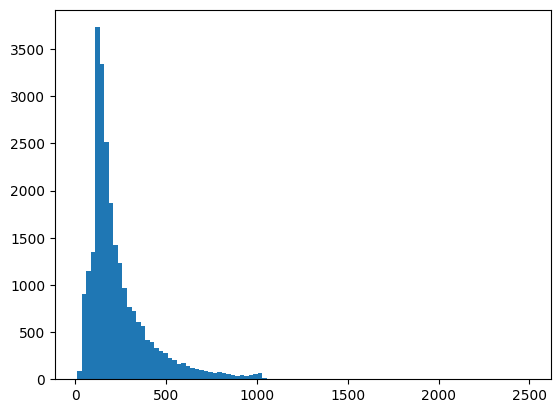

In [32]:
print("type(X_train):", type(X_train))
print("number of training sequences: X_train.shape:", len(X_train))
print("type(X_train[0]):", type(X_train[0]))
print("length of the first training sequence: len(X_train[0]):",len(X_train[0]))
print("length of the second training sequence: len(X_train[1]):",len(X_train[1]))
print("list of data of the first training sequence: X_train[0]:", X_train[0] )
len_list = [len(train) for train in X_train]
print("maximum length of a training sequence:", max(len_list))

import matplotlib.pyplot as plt
plt.hist(len_list, 100);

## Details of how the reviews are encoded

In [33]:
word_to_id = imdb.get_word_index()
word_to_id = {key:(value+param.index_word_from) for key,value in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[1000] ))

<START> although i had seen <UNK> in a theater way back in <UNK> i couldn't remember anything of the plot except for vague images of kurt thomas running and fighting against a backdrop of stone walls and disappointment regarding the ending br br after reading some of the other reviews i picked up a copy of the newly released dvd to once again enter the world of <UNK> br br it turns out this is one of those films produced during the <UNK> that would go directly to video today the film stars <UNK> <UNK> kurt thomas as jonathan <UNK> <UNK> out of the blue to <UNK> the nation of <UNK> to enter and hopefully win the game a <UNK> <UNK> <UNK> by the khan who <UNK> his people by yelling what sounds like <UNK> power the goal of the mission involves the star wars defense system jonathan is trained in the martial arts by princess <UNK> who never speaks or leaves the house once trained tries to blend in with the <UNK> by wearing a bright red <UNK> with <UNK> of blue and white needless to say <UNK>

In [34]:
print("type(y_train):", type(y_train))
print("y_train.shape:", y_train.shape)
y_train[0]

type(y_train): <class 'numpy.ndarray'>
y_train.shape: (25000,)


1

In [35]:
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

AttributeError: 'list' object has no attribute 'shape'

## Data processing

Sequences (represented as a list of values) in `X_train` represent the reviews.
They can have different length $T_x$.
To train the network we should modify them so that they all have the same length `param.T_x`.

We do this by:
- **truncating** the ones that are too long,
- **padding-with-zeros** the ones that are too short.

This can be done at the start of the sequence (`pre`) or at the end (`post`).

In our use-case (rating of reviews), the decision ($\hat{y}$) is taken after reading the whole sentence/review ${x^{<t>}}$. Therefore we will truncate and pad-with-zeroes in `pre` mode (truncate the beginning of the sequence if too long, or add zeroes add the beggining of the sequence if too short).

In [36]:
def do_pad_sequences(sequences, required_len, truncating='pre', padding='pre'):
    """
    Parameters
    ----------
        sequences:  numpy arrays of lists, shape=(25000,)
        required_len:     required length of each sequence after truncating and padding
        padding     'pre' or 'post' mode
        truncating  'pre' or 'post' mode
    Returns
    -------
        padded_sequences    numpy arrays of lists (each list has now length maxlen)
    """
    padded_sequences = []
    if student:
        # ---
        for i in range(len(sequences)):
          if(len(sequences[i]) == required_len):
            padded_sequences.append(sequences[i])
          elif (len(sequences[i]) > required_len):
            # truncate
            padded_sequences.append(sequences[i][-required_len:])
          elif ( len(sequences[i]) < required_len):
            len_ = len(sequences[i])
            padded_sequences.append(np.concatenate( (np.zeros(required_len - len_), sequences[i][:] ) ))
        padded_sequences = np.array(padded_sequences)
        # ---
    return padded_sequences


In [ ]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 2,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 2,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 2,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 2,
 18,
 51,
 36,
 

In [37]:
# --- truncate and pad input sequences
X_train = do_pad_sequences(X_train, required_len=param.T_x, padding='pre', truncating='pre')
X_test = do_pad_sequences(X_test, required_len=param.T_x, padding='pre', truncating='pre')

print("len(X_train[0]):", len(X_train[0]))
print("len(X_train[1]):", len(X_train[1]))

len(X_train[0]): 100
len(X_train[1]): 100


In [38]:
X_train[0]

array([1.415e+03, 3.300e+01, 6.000e+00, 2.200e+01, 1.200e+01, 2.150e+02,
       2.800e+01, 7.700e+01, 5.200e+01, 5.000e+00, 1.400e+01, 4.070e+02,
       1.600e+01, 8.200e+01, 2.000e+00, 8.000e+00, 4.000e+00, 1.070e+02,
       1.170e+02, 2.000e+00, 1.500e+01, 2.560e+02, 4.000e+00, 2.000e+00,
       7.000e+00, 3.766e+03, 5.000e+00, 7.230e+02, 3.600e+01, 7.100e+01,
       4.300e+01, 5.300e+02, 4.760e+02, 2.600e+01, 4.000e+02, 3.170e+02,
       4.600e+01, 7.000e+00, 4.000e+00, 2.000e+00, 1.029e+03, 1.300e+01,
       1.040e+02, 8.800e+01, 4.000e+00, 3.810e+02, 1.500e+01, 2.970e+02,
       9.800e+01, 3.200e+01, 2.071e+03, 5.600e+01, 2.600e+01, 1.410e+02,
       6.000e+00, 1.940e+02, 2.000e+00, 1.800e+01, 4.000e+00, 2.260e+02,
       2.200e+01, 2.100e+01, 1.340e+02, 4.760e+02, 2.600e+01, 4.800e+02,
       5.000e+00, 1.440e+02, 3.000e+01, 2.000e+00, 1.800e+01, 5.100e+01,
       3.600e+01, 2.800e+01, 2.240e+02, 9.200e+01, 2.500e+01, 1.040e+02,
       4.000e+00, 2.260e+02, 6.500e+01, 1.600e+01, 

In [39]:
print("X_train[0]:", len(X_train[20]))

X_train[0]: 100


In [40]:
type(X_train)

numpy.ndarray

# Define training and testing functions

In [41]:
def train_one_epoch(model, data_loader, criterion, optimizer):
    """
    """

    model.train()
    total_loss, total_acc = 0, 0
    for X, y in data_loader:
        optimizer.zero_grad()
        hat_y = model(X)
        loss = criterion(hat_y.squeeze(), y)
        loss.backward() # --- SPECIFIC TO TRAINING
        optimizer.step() # --- SPECIFIC TO TRAINING

        total_loss += loss.item()
        predicted = (hat_y.squeeze() > 0.5).float()
        total_acc += (predicted == y).sum().item()/len(y)

    return total_loss/len(data_loader), total_acc/len(data_loader)



def test_one_epoch(model, data_loader, criterion):
    """
    """

    model.eval()
    total_loss, total_acc =  0, 0
    with torch.no_grad():
        for X, y in data_loader:
            hat_y = model(X)
            loss = criterion(hat_y.squeeze(), y)

            total_loss += loss.item()
            predicted = (hat_y.squeeze() > 0.5).float()
            total_acc += (predicted == y).sum().item()/len(y)

    return total_loss/len(data_loader), total_acc/len(data_loader)




def train(model, train_loader, test_loader, criterion, optimizer, n_epoch):
    """
    """

    for epoch in range(param.n_epoch):

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        print(f"Epoch {epoch + 1}, Loss: {train_loss }, Acc: {train_acc} ")

        test_loss, test_acc = test_one_epoch(model, test_loader, criterion)
        print(f"\tValidation Loss: {test_loss }, Acc: {test_acc} ")


In [42]:
# --- Convert numpy.array to torch.tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets for train and test data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for train and test data
train_loader = DataLoader(train_dataset, batch_size=param.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=param.batch_size, shuffle=False)

# First model



In the first model, you will successively
- step-1) learn word embeddings $e^{<t>}$ of each item of the inut sequence $x^{(t)}$.
    - This is done by learning an embedding matrix $E$. You will use the `nn.Embedding` layer in pytorch.
    - In pytorch, the `nn.Embedding` layer does not really perform a matrix multiplication going from one-hot-encoding to embedding (it would be very costly to do that).
    - In pytorch `nn.Embedding` is a special layer that goes directly from index-of-the-word-in-the-dictionary to the embedding $e^{(t)}$
    - The embedding goes from `param.n_word` dimensions to  `param.n_embedding` dimensions
- step-2) compute the average over time $t$ of the embedding $e^{(t)}$ obtained for each word $x^{(t)}$ of a sequence (you should use `torch.mean`)
- step-3) apply a fully connected (`nn.linear` layer in pytorch) which output activation is a sigmoid (predicting the 0 or 1 rating)

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_01.png">



In [ ]:
nn.Embedding?

In [44]:
if student:
    # --- START CODE HERE (02)
    class SimpleModel(nn.Module):
        def __init__(self, param):
            super(SimpleModel, self).__init__()
            self.embd = nn.Embedding(param.n_word, param.n_embedding, max_norm=True)
            self.linear = nn.Linear(100, 1)

        def forward(self, x):
            x = self.embd(x)
            x = torch.mean(x, [2])
            x = self.linear(x)
            out = torch.sigmoid(x)
            return out

    # --- END CODE HERE



# --- Test
torch.manual_seed(0)
model = SimpleModel(param)
print(X_train_tensor[:param.batch_size, :].size())
print(model(X_train_tensor[:param.batch_size, :]).size())

torch.Size([64, 100])
torch.Size([64, 1])


In [45]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),param.lr)

In [50]:
# Train the model
train(model, train_loader, test_loader, criterion, optimizer, param.n_epoch)

Epoch 1, Loss: 0.6899655421676538, Acc: 0.5527573529411764 
	Validation Loss: 0.6801857283658079, Acc: 0.6135949488491049 
Epoch 2, Loss: 0.6191653465980764, Acc: 0.7079523657289002 
	Validation Loss: 0.5661355933112562, Acc: 0.747786125319693 
Epoch 3, Loss: 0.5098490371271167, Acc: 0.7887148337595907 
	Validation Loss: 0.492083014658345, Acc: 0.7899616368286445 
Epoch 4, Loss: 0.44819400209904936, Acc: 0.8196531329923273 
	Validation Loss: 0.45478515849089074, Acc: 0.8011748721227621 
Epoch 5, Loss: 0.410706848134775, Acc: 0.8368686061381074 
	Validation Loss: 0.4311233018822682, Acc: 0.8126278772378517 
Epoch 6, Loss: 0.38550961352980045, Acc: 0.8471307544757033 
	Validation Loss: 0.41563296790622994, Acc: 0.8202845268542199 
Epoch 7, Loss: 0.3674525448199733, Acc: 0.8531569693094629 
	Validation Loss: 0.40635581104956625, Acc: 0.8239050511508952 
Epoch 8, Loss: 0.3537236739454977, Acc: 0.8575447570332481 
	Validation Loss: 0.39919744390051076, Acc: 0.8256633631713556 


## Results

After only 8 epochs, you should obtain an accuracy "around" 86.7%/ 84.5% for the test data.

## Using the trained embedding to find equivalence between words

Since the embedding is part of the models, we can look at the trained embedding matrix $E$ and use it to get the most similar words (according to the trained matrix $E$) in the dictionary.
You will use the weights of the `nn.Embedding` layer to find the most similar words to `great`. We will use an Euclidean distance for that.

- 1) Retrieve the weights of the `nn.Embedding` layer
- 2) Get the position of `great` in the dictionary
- 3) Knowing this position, get the word-embedding of `great`
- 4) Find (using Euclidean distance), the closest embedded-words to `great`

Remarks:
- you can access a specific layer of the model by using the name you used to define `self.??? = nn.Embedding` in the `__init__`method of `SimpleModel`.
- be careful about the order of the dimensions of the embedding matrix `E`

In [51]:
if student:
    # --- START CODE HERE (03)
    E = model.embd.weight.data
    pos = word_to_id["great"]
    embd_great = E[pos]

    print(E)

    # --- END CODE HERE



tensor([[-0.1640, -0.1680, -0.0332,  ...,  0.2415,  0.1458, -0.1218],
        [-0.0336,  0.0560, -0.0168,  ..., -0.1198,  0.3044, -0.0250],
        [-0.1215,  0.1097,  0.1393,  ..., -0.1816, -0.0279,  0.0771],
        ...,
        [ 0.3289,  0.2391, -0.0988,  ..., -0.1944,  0.1962,  0.1123],
        [-0.0966,  0.0201, -0.1079,  ..., -0.1554,  0.0996, -0.0401],
        [-0.2571, -0.1490, -0.2194,  ..., -0.2288, -0.1202, -0.2196]])


In [56]:
E.shape

torch.Size([5000, 32])

In [57]:
E[pos, :]

tensor([0.1768, 0.1768, 0.1768, 0.1768, 0.1768, 0.1768, 0.1768, 0.1768, 0.1768,
        0.1768, 0.1768, 0.1768, 0.1768, 0.1768, 0.1768, 0.1768, 0.1768, 0.1768,
        0.1768, 0.1768, 0.1768, 0.1768, 0.1768, 0.1768, 0.1768, 0.1768, 0.1768,
        0.1768, 0.1768, 0.1768, 0.1768, 0.1768])

In [58]:
# let's search for the most similar words to "great"
from sklearn.metrics.pairwise import cosine_similarity

similar_words = np.argsort(cosine_similarity(embd_great.reshape(1, -1), E).squeeze())[::-1][:5]
print("The 5 most similar words to 'great' are:")
for i in similar_words:
    print(id_to_word[i])

The 5 most similar words to 'great' are:
wonderful
excellent
superb
fantastic
best


# Second model

In the second model, you will replace step-2 (which was "compute the average over time $t$ of the embedding $e^{(t)}$") by a RNN layer over time.
More precisely you will use a LSTM (`nn.LSTM` layer in pytorch) with `param.n_lstm=100` units (or dimensions) in a Many-To-One configuration

Don't forget that in ou data, the first dimension of `X_train/X_test` represents the batch (`batch_first=True` in pytorch).



In [ ]:
param.n_lstm=100

if student:
    # --- START CODE HERE (04)
    class LstmModel(nn.Module):
        def __init__(self, param):
            super(LstmModel, self).__init__()
            self.embd = nn.Embedding(param.n_word, param.n_embedding, max_norm=True)
            self.lstm = nn.LSTM(param.n_embedding, 100, batch_first=True)
            self.linear = nn.Linear(100, 1)


        def forward(self, x):
            x = self.embd(x)
            _, (x, _) = self.lstm(x)
            x = x[-1]
            x = self.linear(x)
            out = torch.sigmoid(x)
            return out
    # --- END CODE HERE


# --- Test
torch.manual_seed(0)
model = LstmModel(param)
print(X_train_tensor[:param.batch_size, :].size())
print(model(X_train_tensor[:param.batch_size, :]).size())

torch.Size([64, 100])
torch.Size([64, 1])


In [ ]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), param.lr)

In [ ]:
 # Train the model
train(model, train_loader, test_loader, criterion, optimizer, param.n_epoch)

Epoch 1, Loss: 0.5870881499079488, Acc: 0.6691096547314578 
	Validation Loss: 0.5262398856222782, Acc: 0.7276054987212276 
Epoch 2, Loss: 0.37851566007679993, Acc: 0.8358455882352942 
	Validation Loss: 0.37104064580577106, Acc: 0.8380434782608696 
Epoch 3, Loss: 0.3177442296844004, Acc: 0.8666480179028133 
	Validation Loss: 0.3717850907836729, Acc: 0.8420556265984654 
Epoch 4, Loss: 0.28448391149339775, Acc: 0.8832400895140665 
	Validation Loss: 0.3641240746926164, Acc: 0.8441895780051151 
Epoch 5, Loss: 0.2652340763822541, Acc: 0.8922394501278773 
	Validation Loss: 0.39081710942870823, Acc: 0.8444533248081841 
Epoch 6, Loss: 0.25335152738768124, Acc: 0.8984814578005115 
	Validation Loss: 0.3871535580328968, Acc: 0.8410326086956522 
Epoch 7, Loss: 0.23015001084645995, Acc: 0.9086636828644502 
	Validation Loss: 0.42387004299541875, Acc: 0.8366128516624042 
Epoch 8, Loss: 0.21963614678901175, Acc: 0.9149056905370844 
	Validation Loss: 0.424953333023564, Acc: 0.8410166240409207 


## Results

After only 8 epochs, you should obtain an accuracy around 91.1%/ 84.7% for the test data.